In [1]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
plt.rcParams.update({'figure.figsize': (2/3*5.511811263318113, 2/3*5.511811263318113)})


In [2]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [3]:
def compute_inverse_symmetric_matrix(X):
    L, lower = jax.scipy.linalg.cho_factor(X, lower=True)
    u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
    L_t, lower = jax.scipy.linalg.cho_factor(X, lower=False)
    H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
    return H_inv

In [4]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

I0000 00:00:1706692967.090755       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9216, 50 iterations in 0.3769 sec
Iteration  100, KL divergence 0.9541, 50 iterations in 0.3352 sec
Iteration  150, KL divergence 0.9386, 50 iterations in 0.3474 sec
Iteration  200, KL divergence 0.9475, 50 iterations in 0.3554 sec
Iteration  250, KL divergence 0.8335, 50 iterations in 0.3521 sec
   --> Time elapsed: 1.77 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1707, 50 iterations in 0.3490 sec
Iteration  100, KL divergence 0.1707, 50 iterations in 0.3524 sec
Iteration  150, KL divergence 0.1707, 50 iterations in 0.3308 sec
Iteration  200, KL divergence 0.1707, 50 iterations in 0.3560 sec
Iteration 

In [5]:
print(Y_star.mean(axis=0))
Y_star = Y_star - Y_star.mean(axis=0)

[3.55271368e-17 2.22044605e-17]


In [6]:
X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

In [7]:
print(X_flat.shape, Y_flat.shape)

(2500,) (100,)


In [8]:
dy1, H1, J1 = d_y_star_d_x_outer(KL_divergence, X, Y_star)
#H1 = H1 + 1e-5*np.eye(len(H1))

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [9]:
v, w = np.linalg.eigh(H1)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

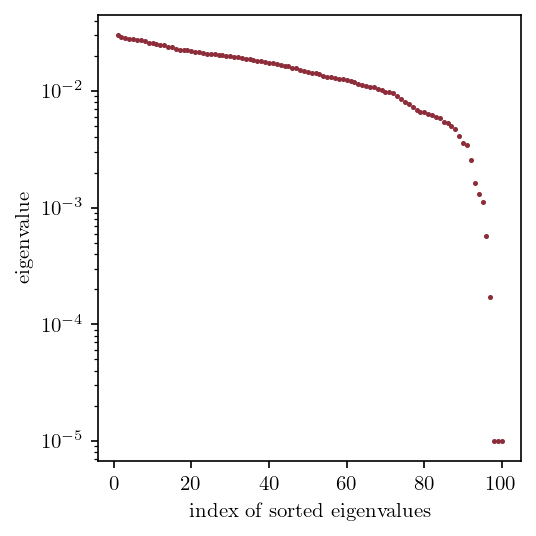

In [10]:
f = plt.figure()
plt.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), s=2)
#sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
plt.yscale('log')
plt.xlabel(r'index of sorted eigenvalues')
plt.ylabel(r'eigenvalue')
plt.tight_layout()
plt.savefig('tsne/eigenvalues.pdf')

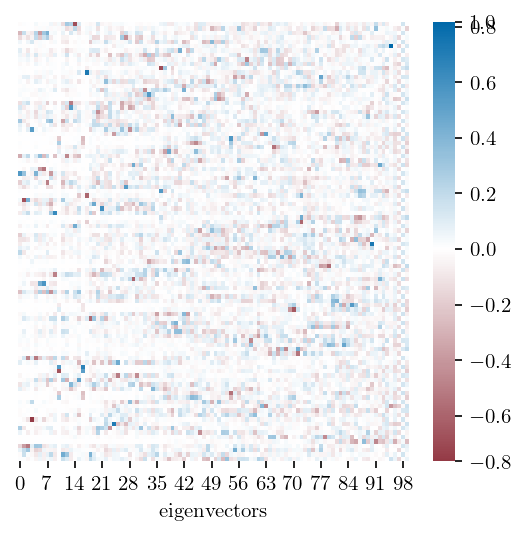

In [11]:
f, ax1 = plt.subplots(1)
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax1, yticklabels=False)
ax1.set_xlabel(r'eigenvectors')
plt.tight_layout()
plt.savefig('tsne/eigenvectors.pdf')

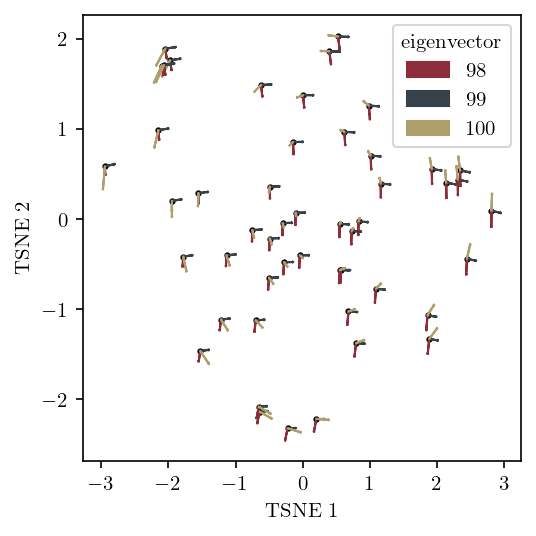

In [12]:
f = plt.figure()
plt.scatter(Y_star[:, 0], Y_star[:, 1], c='black', s=4)
for i, j in enumerate(Y_star):
    if i ==0:
        eigenvector = Y_unflattener(w_sorted[:, 97])
        plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color = palettes.tue_plot[0], label=r'98')
        eigenvector = Y_unflattener(w_sorted[:, 98])
        plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color = palettes.tue_plot[1], label=r'99')
        eigenvector = Y_unflattener(w_sorted[:, 99])
        plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color = palettes.tue_plot[2], label=r'100')
    else:
        eigenvector = Y_unflattener(w_sorted[:, 97])
        plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color = palettes.tue_plot[0])
        eigenvector = Y_unflattener(w_sorted[:, 98])
        plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color = palettes.tue_plot[1])
        eigenvector = Y_unflattener(w_sorted[:, 99])
        plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color = palettes.tue_plot[2])
plt.xlabel(r'TSNE 1')
plt.ylabel(r'TSNE 2')
plt.legend(title = r'eigenvector')
plt.tight_layout()
plt.savefig('tsne/tsne_projection.pdf')

<Axes: >

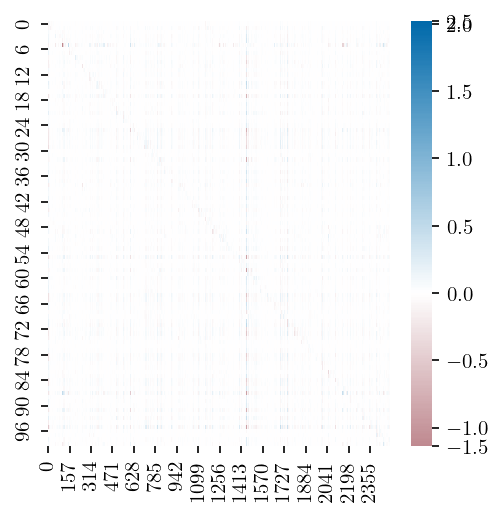

In [13]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy1, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy1), vmax=np.max(dy1))), ax=ax1)

In [14]:
def g(X_flat, Y_flat, X_unflattener, Y_unflattener, u, v):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat+u@v.T)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [15]:
w_sorted_sub = w_sorted[:, :97]
#w_sorted_sub = w_sorted
g_fun = lambda u: g(X_flat, Y_flat, X_unflattener, Y_unflattener, u, w_sorted_sub)

In [16]:
H_g = jax.hessian(g_fun)(np.zeros(w_sorted_sub.shape[1]))

Computing pairwise distances...
Starting binary search
Entered binary search function


In [17]:
H_g.shape

(97, 97)

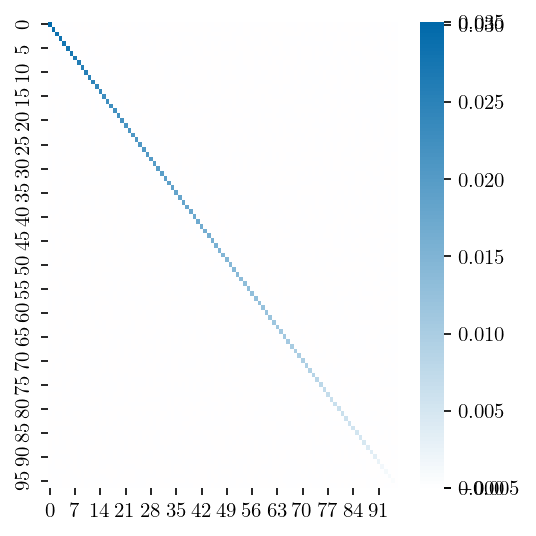

In [18]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H_g, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_g), vmax=np.max(H_g))), ax=ax1)
plt.tight_layout()
plt.savefig('tsne/GHessian.pdf')

In [19]:
H_g_inv = compute_inverse_symmetric_matrix(H_g)

In [20]:
J_g_mixed = jacfwd(jacfwd(g, argnums=4), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener, np.zeros(w_sorted_sub.shape[1]), w_sorted_sub)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [21]:
J_g_mixed.shape

(97, 2500)

In [22]:
du_dx = -H_g_inv @ J_g_mixed

In [23]:
du_dx.shape

(97, 2500)

In [24]:
dy_dx = w_sorted_sub @ du_dx

<Axes: >

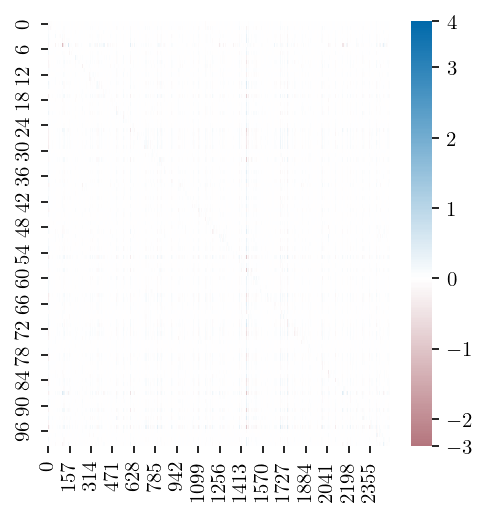

In [25]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_dx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(du_dx), vmax=np.max(du_dx))), ax=ax1)

<Axes: >

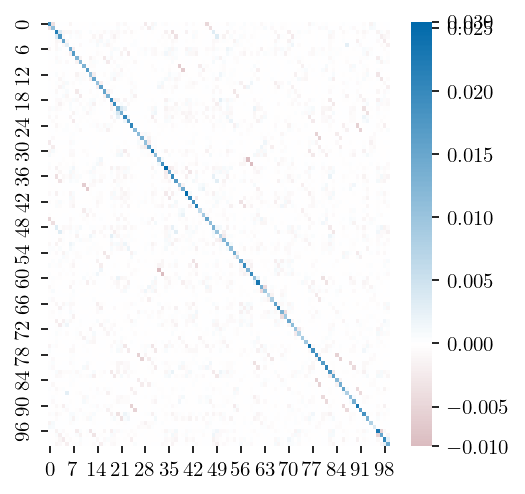

In [26]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H1, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H1), vmax=np.max(H1))), ax=ax1)

In [27]:
f = lambda y: KL_divergence(X_flat, y, X_unflattener, Y_unflattener)

In [28]:
df = lambda y: jax.grad(f)(y)

In [29]:
df2 = lambda y: jax.jacrev(f)(y)

In [30]:
ddf = lambda y: jacfwd(df)(y)

In [31]:
ddf(Y_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array([[ 1.89862028e-02, -3.77861690e-03, -2.78304651e-05, ...,
        -1.39734344e-04,  4.90377133e-05,  9.10659874e-05],
       [-3.77861736e-03,  1.07681956e-02,  1.83091161e-05, ...,
        -2.60197812e-05, -9.95599294e-06,  1.48283798e-05],
       [-2.78304215e-05,  1.83091252e-05,  2.18242444e-02, ...,
         4.31239430e-04, -2.14690110e-04, -1.09219295e-03],
       ...,
       [-1.39734315e-04, -2.60197921e-05,  4.31239197e-04, ...,
         1.49308825e-02,  9.65206418e-05, -1.16236438e-03],
       [ 4.90376551e-05, -9.95598748e-06, -2.14689644e-04, ...,
         9.65207146e-05,  2.01976430e-02,  2.47694715e-03],
       [ 9.10659728e-05,  1.48283816e-05, -1.09219295e-03, ...,
        -1.16236438e-03,  2.47694738e-03,  1.46333538e-02]],      dtype=float32)

In [32]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [33]:
f2 = lambda y: KL_divergence_dy(X_flat, y, X_unflattener, Y_unflattener)
df_2 = lambda y: jax.jacrev(f2)(y)

In [34]:
print(df_2(Y_flat))

Computing pairwise distances...
Starting binary search
Entered binary search function
[[ 1.8986207e-02 -3.7786174e-03 -2.7830407e-05 ... -1.3973436e-04
   4.9037655e-05  9.1065980e-05]
 [-3.7786181e-03  1.0768201e-02  1.8309122e-05 ... -2.6019845e-05
  -9.9559902e-06  1.4828358e-05]
 [-2.7830421e-05  1.8309122e-05  2.1824252e-02 ...  4.3123937e-04
  -2.1469014e-04 -1.0921931e-03]
 ...
 [-1.3973437e-04 -2.6019843e-05  4.3123949e-04 ...  1.4930887e-02
   9.6520671e-05 -1.1623648e-03]
 [ 4.9037757e-05 -9.9559875e-06 -2.1469011e-04 ...  9.6520635e-05
   2.0197650e-02  2.4769469e-03]
 [ 9.1066002e-05  1.4828349e-05 -1.0921931e-03 ... -1.1623648e-03
   2.4769467e-03  1.4633360e-02]]


In [35]:
H = jax.hessian(KL_divergence, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [36]:
v, w = np.linalg.eigh(H1)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

In [37]:
u = lambda y: (y - Y_flat) @ w_sorted

In [38]:
def g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, v):
    """
    (R^nxp x R^nxp)--> R^nx2
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat+u@v.T)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, num = y2q(Y)
    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    return np.ravel(4 * np.sum((PQ_exp * Y_diffs_wt), axis=1))[:97] # Nx2

In [39]:
w_sorted_sub = w_sorted[:, :97]
#w_sorted_sub = w_sorted
g_fun2 = lambda u: g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, w_sorted_sub)

In [40]:
w_sorted_sub.shape

(100, 97)

In [41]:
dg = jax.jacrev(g_fun2)(np.zeros(w_sorted_sub.shape[1]))

Computing pairwise distances...
Starting binary search
Entered binary search function


In [42]:
dg.shape

(97, 97)

<Axes: >

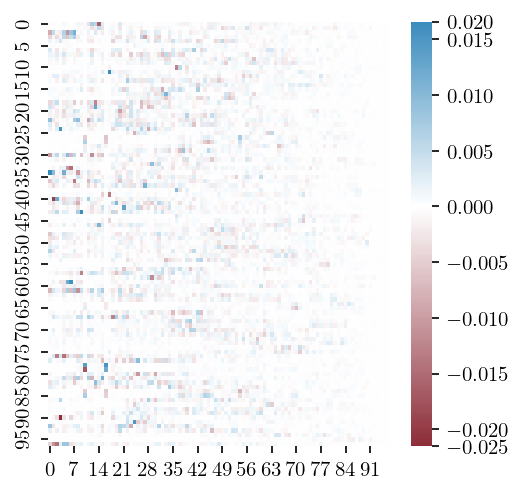

In [43]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg), vmax=np.max(dg))), ax=ax1)

In [44]:
a, s, b = np.linalg.svd(dg)

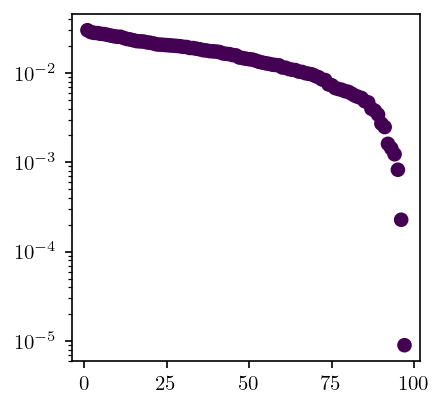

In [45]:
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

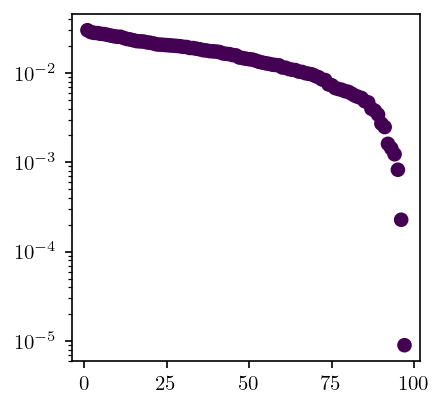

In [46]:
a, s, b = np.linalg.svd(dg[:97, :97])
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

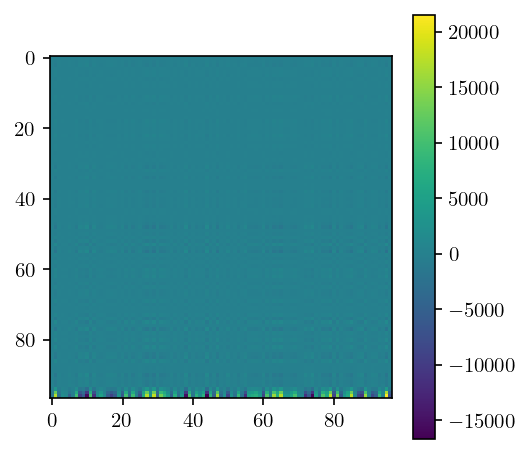

In [47]:
plt.imshow(np.linalg.inv(dg))
plt.colorbar()

In [48]:
g_fun_x = lambda x: g2(x, Y_flat, X_unflattener, Y_unflattener, np.zeros(w_sorted_sub.shape[1]), w_sorted_sub)
dg_x = jax.jacrev(g_fun_x)(X_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [49]:
dg_x[:, 0]

Array([ 2.71177106e-03, -1.85863080e-03, -8.00809721e-06,  4.27812574e-06,
        5.84936470e-06,  7.62308582e-06, -2.52325379e-04,  4.34006070e-05,
        8.22267248e-06, -3.72359409e-06, -1.78750324e-05, -1.18349017e-05,
       -7.29066687e-06, -1.17149175e-05, -5.32145441e-06,  1.79516719e-05,
        7.07566687e-06, -6.32392698e-08, -6.09963899e-06, -3.89173601e-06,
       -1.12877489e-04,  1.67691396e-05, -4.60523966e-04,  1.33356589e-04,
        7.67394886e-06,  4.65213560e-07, -1.65505990e-05,  3.64209991e-05,
       -8.13397637e-05,  8.45569477e-04, -2.51132617e-04,  1.18319440e-04,
        6.91218384e-06,  1.62713513e-05, -9.30120514e-05,  1.90247138e-05,
       -2.10177259e-05,  1.09715374e-05, -4.36612936e-06, -2.00370559e-05,
       -1.30162967e-04,  3.83968218e-05, -1.09606262e-04,  1.89137791e-05,
        1.80498264e-05, -4.90108687e-05, -5.79531406e-05, -1.89799233e-04,
       -1.46708626e-05,  7.75077388e-06, -1.22598885e-06, -1.22460197e-05,
       -8.56851984e-05,  

In [50]:
J1[:, 0]

Array([ 2.71176966e-03, -1.85863150e-03, -8.00809175e-06,  4.27811983e-06,
        5.84936151e-06,  7.62307855e-06, -2.52325321e-04,  4.34005960e-05,
        8.22267430e-06, -3.72358727e-06, -1.78750161e-05, -1.18348926e-05,
       -7.29065869e-06, -1.17149066e-05, -5.32145668e-06,  1.79516628e-05,
        7.07565869e-06, -6.32367119e-08, -6.09963627e-06, -3.89173874e-06,
       -1.12877453e-04,  1.67691487e-05, -4.60523734e-04,  1.33356574e-04,
        7.67394613e-06,  4.65210462e-07, -1.65505899e-05,  3.64210064e-05,
       -8.13398001e-05,  8.45569593e-04, -2.51132587e-04,  1.18319433e-04,
        6.91218156e-06,  1.62713332e-05, -9.30120150e-05,  1.90247138e-05,
       -2.10177241e-05,  1.09715347e-05, -4.36612436e-06, -2.00370378e-05,
       -1.30162938e-04,  3.83968181e-05, -1.09606255e-04,  1.89137718e-05,
        1.80498137e-05, -4.90108323e-05, -5.79531225e-05, -1.89799248e-04,
       -1.46708599e-05,  7.75076751e-06, -1.22597612e-06, -1.22460169e-05,
       -8.56851912e-05,  

In [51]:
du_dx = - np.linalg.inv(dg) @ dg_x

In [52]:
dy_dx = w_sorted_sub @ du_dx

In [53]:
dy_dx.shape

(100, 2500)

<Axes: >

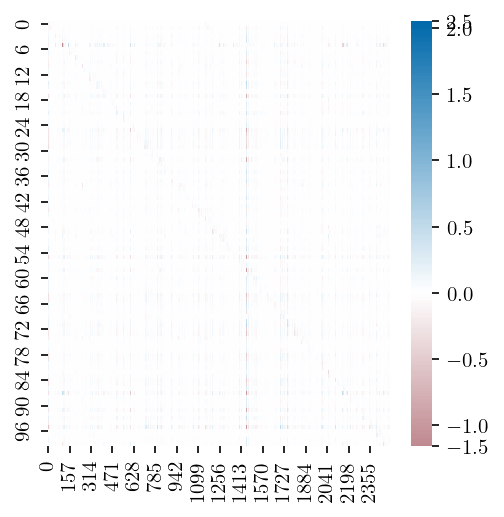

In [54]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_dx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy_dx), vmax=np.max(dy_dx))), ax=ax1)

In [55]:
plt.imshow(dy_dx-dy)
plt.colorbar()

NameError: name 'dy' is not defined

In [ ]:
dy, H, J = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

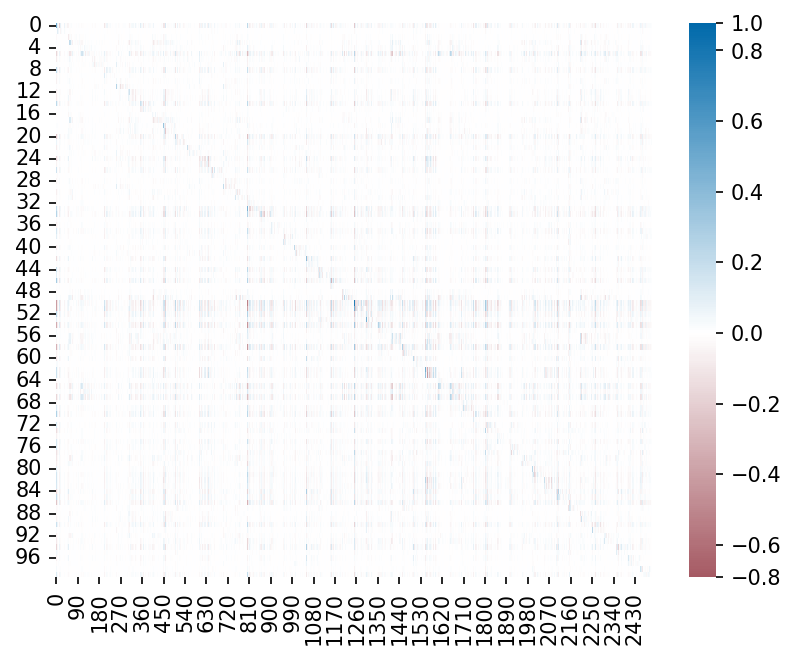

In [ ]:
f = plt.figure()
sns.heatmap(dy, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy), vmax=np.max(dy))))

<AxesSubplot: >

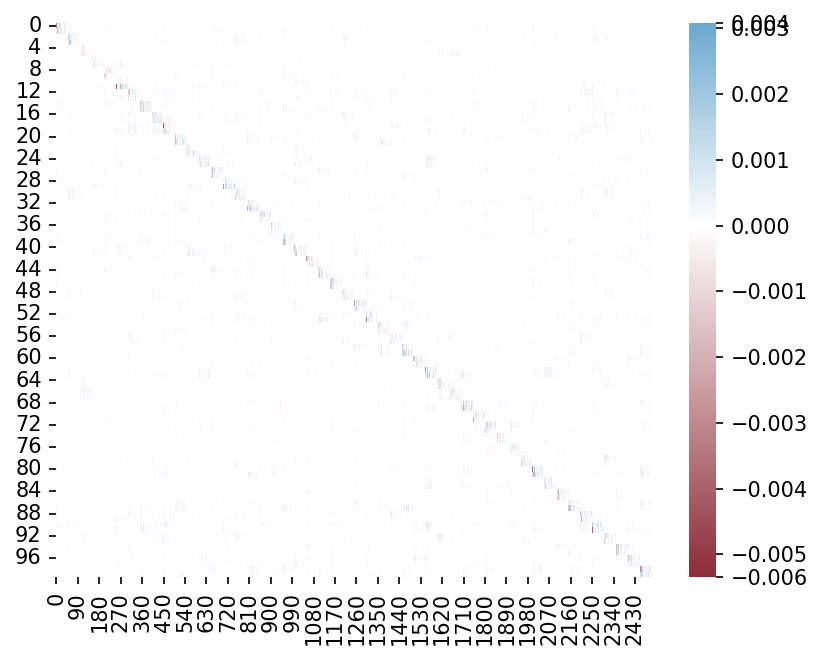

In [ ]:
f = plt.figure()
sns.heatmap(J, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J), vmax=np.max(J))))

<AxesSubplot: >

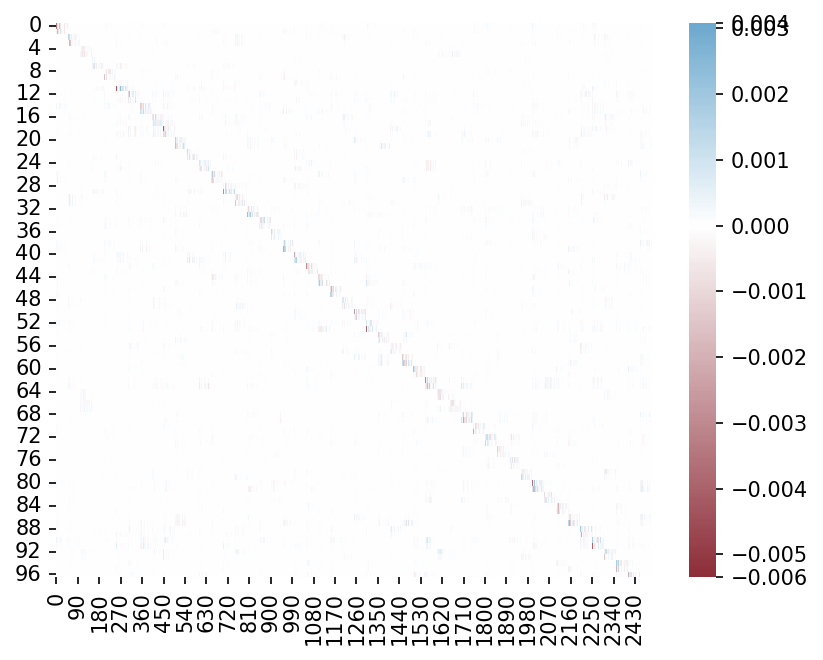

In [ ]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg_x, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg_x), vmax=np.max(dg_x))), ax=ax1)

<AxesSubplot: >

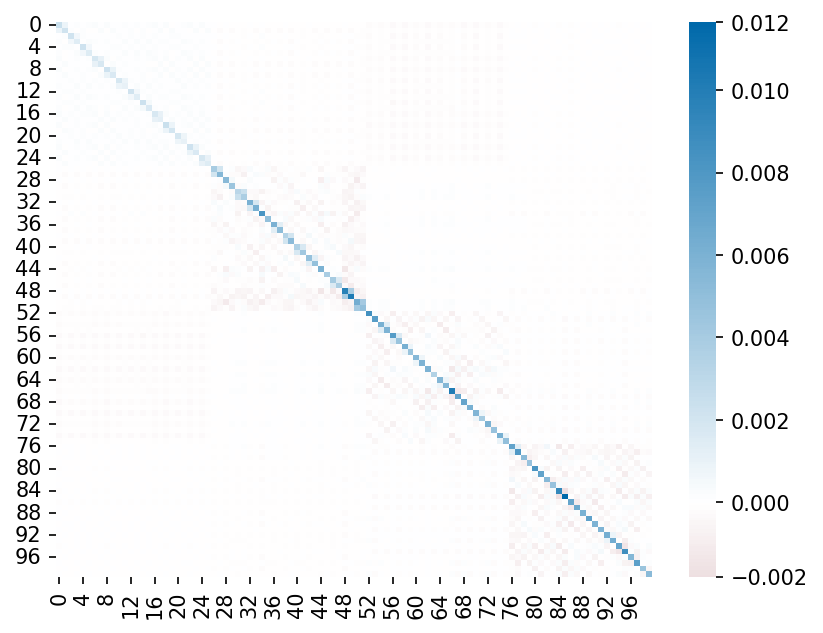

In [ ]:
f = plt.figure()
sns.heatmap(H, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H), vmax=np.max(H))))

In [ ]:
inv = np.linalg.inv(dg)
#from scipy.linalg import pinv
#inv = pinv(dg)
print(dg.shape)

(97, 97)


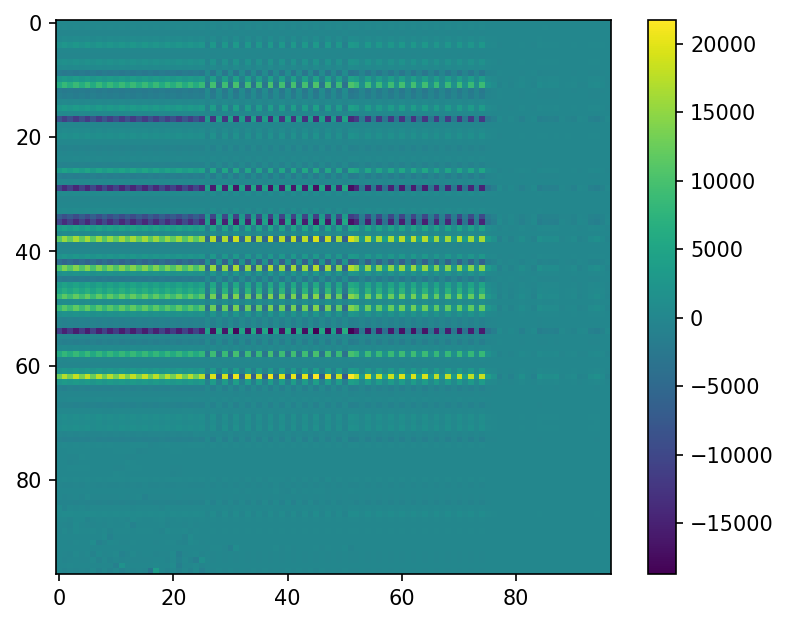

In [ ]:
plt.imshow(inv)
plt.colorbar()

In [ ]:
H = H +1e-5*np.eye(len(H))

<AxesSubplot: >

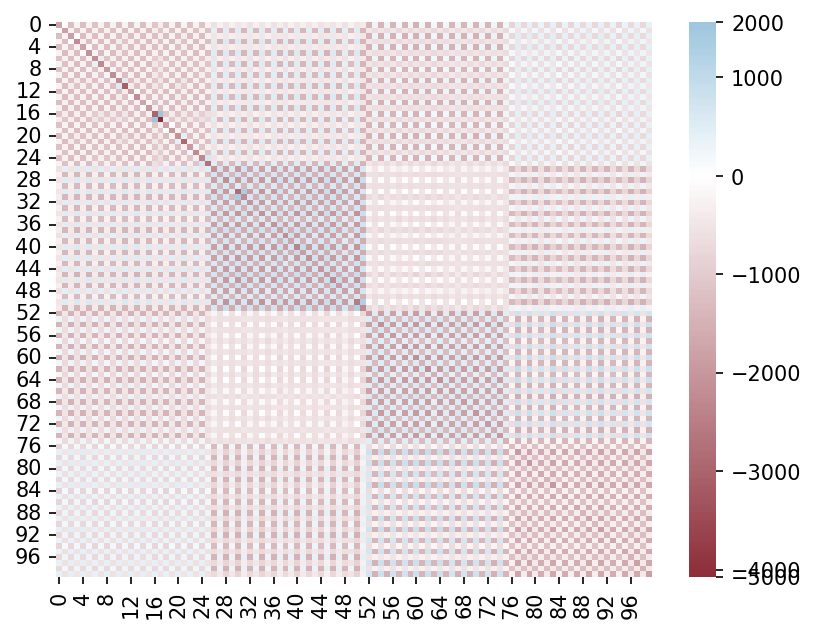

In [ ]:
H_inv = compute_inverse_symmetric_matrix(H)
f = plt.figure()
sns.heatmap(-H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(-H_inv), vmax=np.max(-H_inv))))

In [ ]:
print(dg.shape, w_sorted_sub.shape)

(97, 97) (100, 97)


<AxesSubplot: >

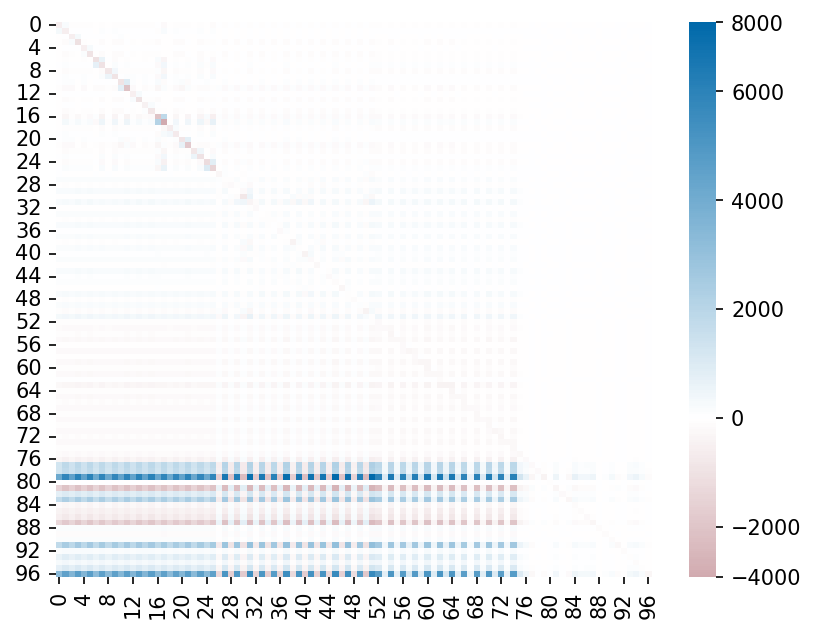

In [ ]:
x = w_sorted_sub[0:97] @ (-np.linalg.inv(dg))
f = plt.figure()
sns.heatmap(x, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(x), vmax=np.max(x))))

In [ ]:
print(x)

[[-6.13987427e+02  1.74850739e+02 -8.79502106e+01 ... -1.16080523e+01
  -4.30453110e+00  1.51654387e+00]
 [ 2.84549255e+02 -5.98586243e+02  5.05498390e+01 ...  5.53352976e+00
   3.19790602e+00  1.75312236e-02]
 [-1.61643906e+01  4.37316666e+01 -5.72087341e+02 ... -3.61460757e+00
   5.53813457e+00 -1.82188116e-02]
 ...
 [ 2.57996735e+02  3.41391632e+02  2.80733978e+02 ... -1.27178566e+02
  -1.57221270e+01 -1.61185207e+01]
 [ 7.04000061e+02  1.00413611e+03  7.58434814e+02 ...  5.92279243e+01
  -7.56790009e+01 -2.75120087e+01]
 [ 3.27204150e+03  4.52247705e+03  3.52549634e+03 ...  4.03625916e+02
   2.06548370e+02 -3.11581146e+02]]


In [ ]:
dy_dx

Array([[-1.0310648e-02, -1.7709004e-02, -8.8911112e-03, ...,
        -5.5248250e-04,  6.6873645e-06, -3.3713764e-04],
       [ 1.6438399e-02,  5.1229484e-03,  2.8841509e-03, ...,
         3.7845437e-04,  1.2790735e-04,  1.7202062e-04],
       [-8.7798387e-04,  4.0595964e-04, -6.1773008e-04, ...,
        -2.8386369e-04,  3.1077757e-04, -1.2233062e-04],
       ...,
       [-3.3856527e-04,  2.2412204e-04, -4.5626273e-04, ...,
        -2.3167807e-04, -3.2732575e-04, -7.0427766e-04],
       [ 8.4290333e-04, -6.5993820e-04,  1.1146279e-03, ...,
         3.0912431e-03, -1.1406816e-02,  1.9713312e-03],
       [-4.6608126e-04,  3.1478333e-04, -5.8381358e-04, ...,
         4.9121892e-03,  6.5324930e-03,  9.1032181e-03]], dtype=float32)

In [ ]:
dy

Array([[-1.01952795e-02, -1.75882261e-02, -8.82642437e-03, ...,
        -5.48430718e-04,  6.13746624e-06, -3.34761047e-04],
       [ 1.62888691e-02,  5.03046531e-03,  2.83556106e-03, ...,
         3.76047363e-04,  1.28008789e-04,  1.71470077e-04],
       [-8.62163783e-04,  4.10228735e-04, -6.07913302e-04, ...,
        -2.81102024e-04,  3.08636052e-04, -1.20790042e-04],
       ...,
       [-3.33274103e-04,  2.18804140e-04, -4.51751635e-04, ...,
        -2.27607423e-04, -3.25435190e-04, -6.93955284e-04],
       [ 8.36487219e-04, -6.55665935e-04,  1.10711064e-03, ...,
         3.08129075e-03, -1.13810562e-02,  1.96215464e-03],
       [-4.65123041e-04,  3.19882965e-04, -5.80761873e-04, ...,
         4.89935745e-03,  6.51723519e-03,  9.07334313e-03]],      dtype=float32)

In [ ]:
-H_inv @ J

Array([[-1.00831203e-02, -1.74699966e-02, -8.76318477e-03, ...,
        -5.44547103e-04,  5.52879646e-06, -3.32952477e-04],
       [ 1.61429346e-02,  4.94112633e-03,  2.78836396e-03, ...,
         3.73479212e-04,  1.27772801e-04,  1.70256011e-04],
       [-8.47158197e-04,  4.14287701e-04, -5.98471670e-04, ...,
        -2.78569758e-04,  3.06324102e-04, -1.19980425e-04],
       ...,
       [-3.29808798e-04,  2.17823530e-04, -4.48053761e-04, ...,
        -2.25736760e-04, -3.26061621e-04, -6.91367313e-04],
       [ 8.30730540e-04, -6.52682676e-04,  1.09986891e-03, ...,
         3.07196868e-03, -1.13547873e-02,  1.95513153e-03],
       [-4.61280550e-04,  3.18522681e-04, -5.76499966e-04, ...,
         4.89016715e-03,  6.50605559e-03,  9.05637350e-03]],      dtype=float32)

In [ ]:
lu, piv= jax.scipy.linalg.lu_factor(dg)
hinte = jax.scipy.linalg.lu_solve((lu, piv), -dg_x)

In [ ]:
w_sorted_sub @ hinte

Array([[-1.0310642e-02, -1.7709015e-02, -8.8911084e-03, ...,
        -5.5248168e-04,  6.6866701e-06, -3.3714020e-04],
       [ 1.6438400e-02,  5.1229461e-03,  2.8841482e-03, ...,
         3.7845710e-04,  1.2790514e-04,  1.7201962e-04],
       [-8.7797944e-04,  4.0595519e-04, -6.1773049e-04, ...,
        -2.8386444e-04,  3.1077949e-04, -1.2232950e-04],
       ...,
       [-3.3823299e-04,  2.2394460e-04, -4.5625778e-04, ...,
        -2.3161335e-04, -3.2721323e-04, -7.0423307e-04],
       [ 8.4279961e-04, -6.5978727e-04,  1.1146292e-03, ...,
         3.0912210e-03, -1.1406810e-02,  1.9712921e-03],
       [-4.6642488e-04,  3.1481628e-04, -5.8381527e-04, ...,
         4.9120458e-03,  6.5323850e-03,  9.1030868e-03]], dtype=float32)

In [ ]:
lu, piv= jax.scipy.linalg.lu_factor(H)
jax.scipy.linalg.lu_solve((lu, piv), -J)

Array([[-1.00831771e-02, -1.74700152e-02, -8.76320805e-03, ...,
        -5.44531678e-04,  5.53585460e-06, -3.32925847e-04],
       [ 1.61429178e-02,  4.94114263e-03,  2.78833346e-03, ...,
         3.73464718e-04,  1.27817126e-04,  1.70248575e-04],
       [-8.47207091e-04,  4.14288108e-04, -5.98492683e-04, ...,
        -2.78560765e-04,  3.06335918e-04, -1.19955490e-04],
       ...,
       [-3.29787465e-04,  2.17826251e-04, -4.48061473e-04, ...,
        -2.25716227e-04, -3.26047710e-04, -6.91342168e-04],
       [ 8.30709818e-04, -6.52690360e-04,  1.09986472e-03, ...,
         3.07201291e-03, -1.13547975e-02,  1.95518718e-03],
       [-4.61254880e-04,  3.18525272e-04, -5.76505088e-04, ...,
         4.89018392e-03,  6.50607888e-03,  9.05639119e-03]],      dtype=float32)

In [ ]:
U = Y_flat @ w_sorted
dy2, H2, J2 = d_y_star_d_x_outer(KL_divergence, X, Y_unflattener(U))

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


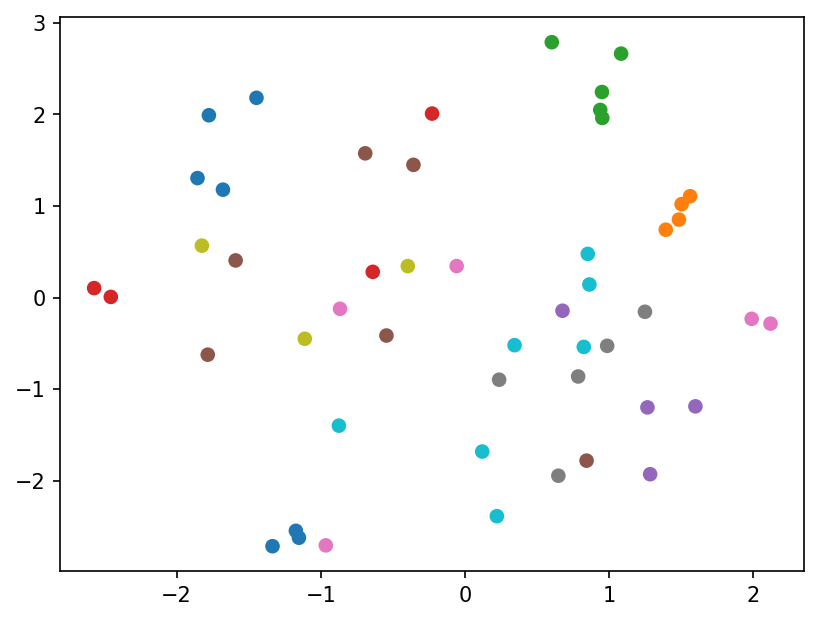

In [ ]:
f = plt.figure()
plt.scatter(*Y_star.T, c=y, cmap='tab10')

In [ ]:
Y_unflattener(U).T

Array([[ 2.09443551e-02,  5.32265343e-02,  9.90514159e-02,
         6.01038150e-02, -8.18646178e-02, -1.38164312e-01,
        -2.47916505e-01,  2.48546824e-02, -2.37660512e-01,
         7.48367086e-02,  3.47088166e-02,  7.77415782e-02,
         1.95417538e-01,  1.09379716e-01, -4.61339086e-01,
        -6.89975619e-02,  4.98384498e-02,  3.13536167e-01,
        -4.28944230e-02, -8.26675817e-03, -6.58847541e-02,
         8.49189330e-03, -1.51123814e-02, -1.95083499e-01,
        -1.10428229e-01, -1.87688768e-01,  1.26726523e-01,
         3.02240014e-01, -2.24319905e-01, -1.72766507e-01,
         1.54152840e-01,  1.92579359e-01,  3.01808361e-02,
        -1.64338723e-01, -2.93625385e-01, -2.69989014e-01,
         3.60410154e-01,  4.33104813e-01, -6.00864530e-01,
        -4.48124595e-02,  3.87226254e-01,  4.31187898e-02,
         1.17648207e-01, -2.52621204e-01,  1.45383194e-01,
        -2.80053943e-01, -7.31560946e-01, -1.38000727e-01,
         1.04170036e+00,  3.93613300e-05],
       [-7.26

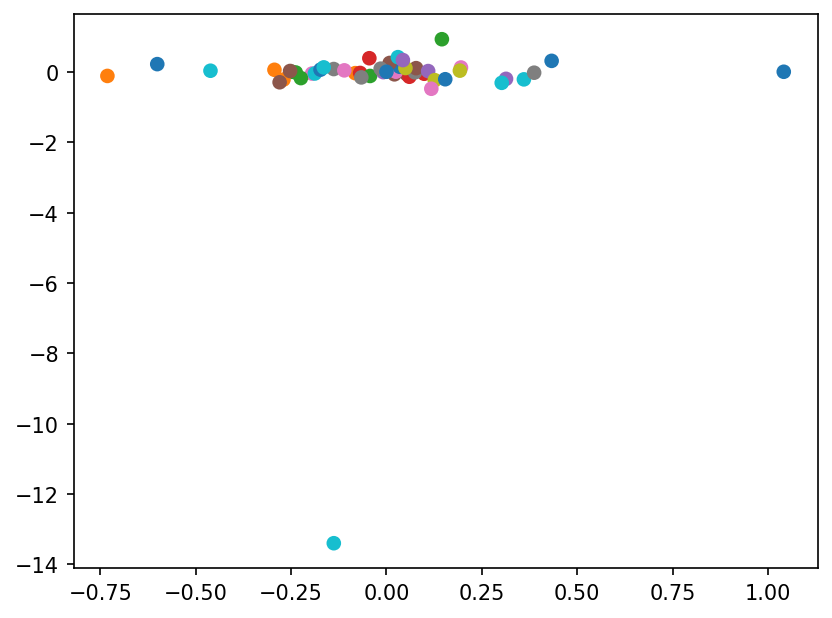

In [ ]:
f = plt.figure()
plt.scatter(*Y_unflattener(U).T, c=y, cmap='tab10')

<AxesSubplot: >

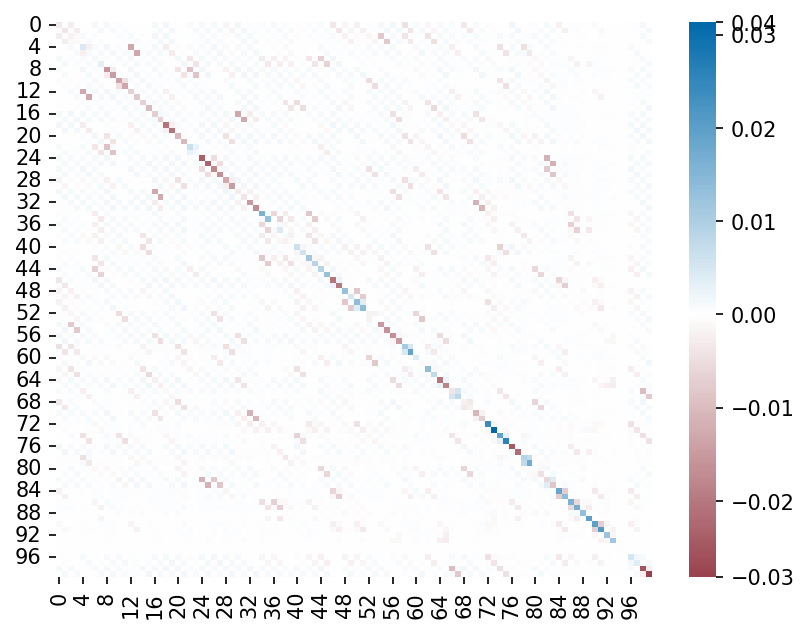

In [ ]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H2, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H2), vmax=np.max(H2))), ax=ax1)

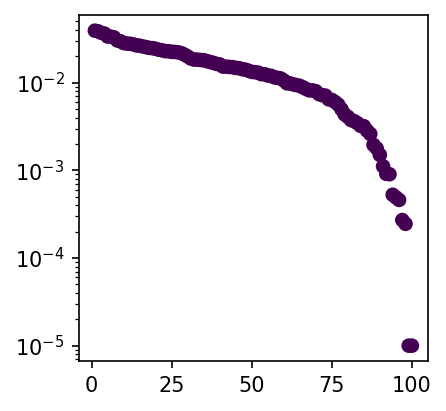

In [ ]:
a, s, b = np.linalg.svd(H2)
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

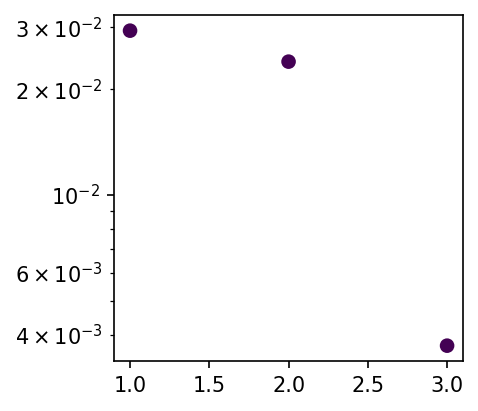

In [ ]:
a, s, b = np.linalg.svd(H2[97:, 97:])
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

In [ ]:
def g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, v):
    """
    (R^nxp x R^nxp)--> R^nx2
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat+u@v.T)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, num = y2q(Y)
    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    return np.ravel(4 * np.sum((PQ_exp * Y_diffs_wt), axis=1))@v

In [ ]:
w_sorted_sub = w_sorted
g_fun2 = lambda u: g2(X_flat, Y_flat, X_unflattener, Y_unflattener, u, w_sorted_sub)

In [ ]:
dg = jax.jacrev(g_fun2)(np.zeros(w_sorted_sub.shape[1]))

Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

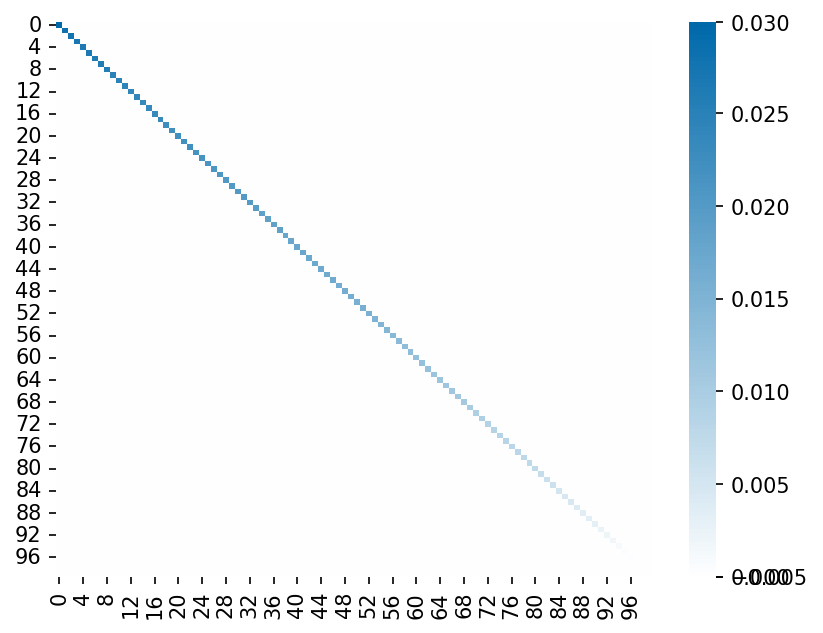

In [ ]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg), vmax=np.max(dg))), ax=ax1)

In [ ]:
a, s, b = np.linalg.svd(dg[97:,97:])

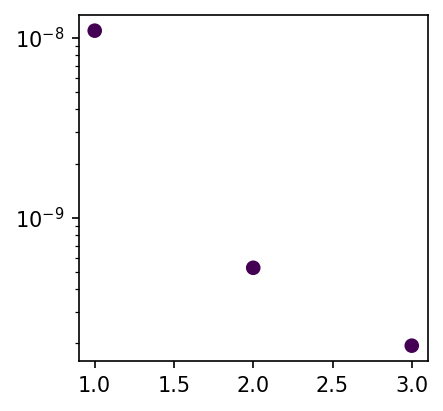

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))), c=[1 if i>0 else 0 for i in np.flip(np.sort(s))])
ax1.set_yscale('log')

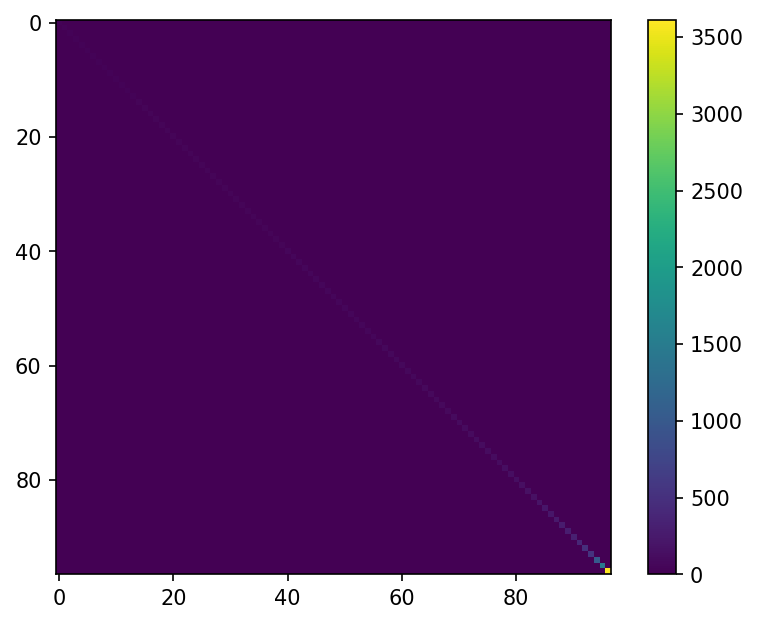

In [ ]:
plt.imshow(np.linalg.inv(dg[:97, :97]))
plt.colorbar()

In [ ]:
g_fun_x = lambda x: g2(x, Y_flat, X_unflattener, Y_unflattener, np.zeros(w_sorted_sub.shape[1]), w_sorted_sub)
dg_x = jax.jacrev(g_fun_x)(X_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

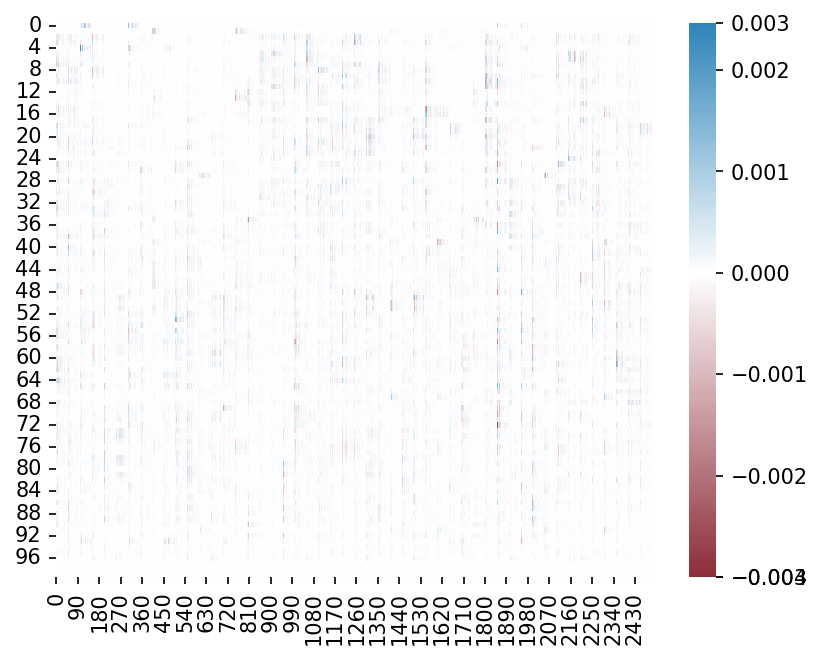

In [ ]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dg_x, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dg_x), vmax=np.max(dg_x))), ax=ax1)

In [ ]:
du_dx = - np.linalg.inv(dg) @ dg_x

In [ ]:
dy_dx = w_sorted_sub @ du_dx

<AxesSubplot: >

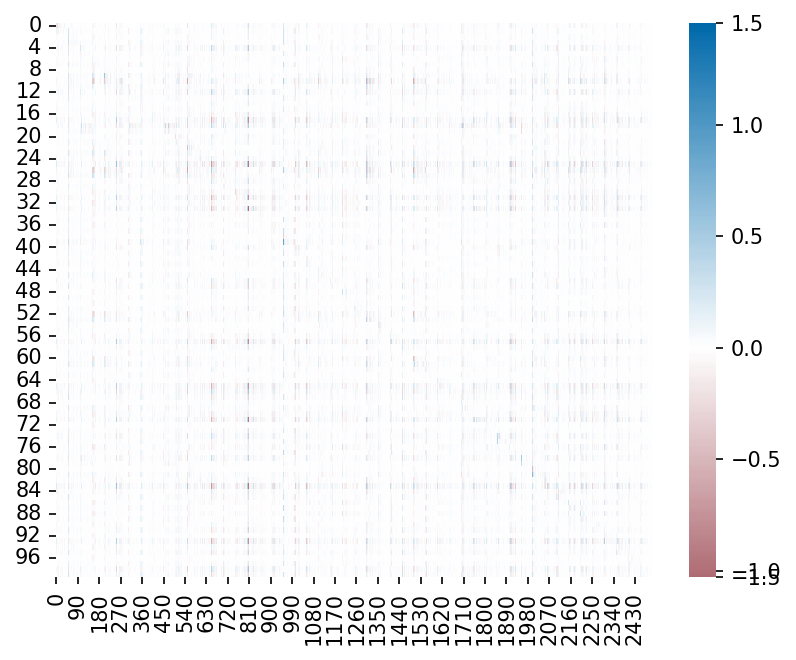

In [ ]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_dx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy_dx), vmax=np.max(dy_dx))), ax=ax1)

In [ ]:
f2(Y_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array([ 1.63505320e-07, -2.62778485e-07, -1.04133505e-07,  2.87545845e-07,
       -4.50090738e-07, -3.99537385e-07,  2.24215910e-07, -1.08178938e-07,
        3.10261385e-07,  3.39729013e-07,  1.86264515e-07,  1.02561899e-07,
        5.85423550e-07, -6.95232302e-07,  1.94530003e-07, -1.75787136e-08,
        3.79004632e-08, -2.78232619e-07,  1.14378054e-08, -2.01631337e-07,
        3.83326551e-07, -3.47208697e-08,  8.41973815e-08, -6.33299351e-08,
       -5.27768862e-07, -1.35041773e-07,  1.15018338e-07, -4.57221176e-08,
        1.13854185e-07, -3.33006028e-07, -5.07570803e-08,  2.46684067e-07,
       -2.08354322e-07, -1.47847459e-07,  8.34697857e-07,  4.11644578e-07,
       -5.69561962e-08, -1.97323970e-07,  2.08849087e-07, -7.02275429e-08,
        4.80213203e-08,  1.95577741e-08, -1.52504072e-08,  2.68133590e-07,
       -2.53377948e-07,  2.58689397e-07, -7.17409421e-08, -8.30623321e-08,
       -4.80911694e-07, -2.00700015e-07,  9.88366082e-08,  1.01135811e-06,
       -2.57015927e-07, -

In [ ]:
f2(Y_flat + 5)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array([ 1.62690412e-07, -2.60217348e-07, -1.06403604e-07,  2.94996426e-07,
       -4.46976628e-07, -3.88128683e-07,  2.20374204e-07, -1.10303517e-07,
        2.91271135e-07,  3.33006028e-07,  1.64727680e-07,  8.53324309e-08,
        5.85358066e-07, -6.90750312e-07,  2.15950422e-07, -8.03265721e-09,
        4.64351615e-08, -2.74914782e-07,  3.30328476e-08, -1.77184120e-07,
        3.77069227e-07, -3.96976247e-08,  7.36763468e-08, -7.98609108e-08,
       -5.27536031e-07, -1.34110451e-07,  1.00233592e-07, -3.13739292e-08,
        1.14436261e-07, -3.34985089e-07, -5.71599230e-08,  2.55298801e-07,
       -2.28115823e-07, -1.54133886e-07,  8.35279934e-07,  4.09316272e-07,
       -4.43542376e-08, -1.98837370e-07,  1.99768692e-07, -7.50296749e-08,
        6.48433343e-08,  2.09547579e-08, -1.16415322e-08,  2.78145308e-07,
       -2.46393029e-07,  2.54236511e-07, -6.53672032e-08, -7.59318937e-08,
       -4.82657924e-07, -2.15484761e-07,  9.48784873e-08,  9.99774784e-07,
       -2.65761628e-07, -